In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline
import math
import nltk
import string
from itertools import compress
from nltk import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

import stanza
stanza.download('es')
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma,depparse')

Datos ya preprocesados y lematizados, filtrados por:
- Promotores 
- Categorias: 'tourist atraction','national park','church'
- Idioma Español

In [2]:
datos=pd.read_csv('Base de datos/datos_lematizados.csv')
datos['traduccion']=datos['traduccion'].astype(str)
datos = datos.drop(datos.columns[0], axis=1)
datos

Id                      placeId  \
0         257  ChIJLTxz75CNIpYRWxjHYdRhlrc   
1         258  ChIJLTxz75CNIpYRWxjHYdRhlrc   
2         259  ChIJLTxz75CNIpYRWxjHYdRhlrc   
3         260  ChIJLTxz75CNIpYRWxjHYdRhlrc   
4         262  ChIJLTxz75CNIpYRWxjHYdRhlrc   
...       ...                          ...   
12654  278290  ChIJvfJSUDOKF5YRZe9GgfAODLc   
12655  278292  ChIJvfJSUDOKF5YRZe9GgfAODLc   
12656  278306  ChIJH4JP_-Tb9b0RzrxQFWoFaew   
12657  278311  ChIJH4JP_-Tb9b0RzrxQFWoFaew   
12658  278314  ChIJ766vtHlhF5YRyzMnbS1Z0iU   

                                 place name Categoria query  Year  \
0      Acceso a la Playa de Quincho Mutrico   national park  2023   
1      Acceso a la Playa de Quincho Mutrico   national park  2023   
2      Acceso a la Playa de Quincho Mutrico   national park  2022   
3      Acceso a la Playa de Quincho Mutrico   national park  2022   
4      Acceso a la Playa de Quincho Mutrico   national park  2022   
...                                     ...             ...   ...   
12654                       Portal Del Lago   national park  2018   
12655                       Portal Del Lago   national park  2018   
12656          Reserva Nacional Lago Palena   national park  2018   
12657          Reserva Nacional Lago Palena   national park  2016   
12658                 Vicente Perez Rosales   national park  2023   

                                                    text  stars Idioma  \
0      Lugar específico para disfrutar de pesca con f...    4.0     es   
1                                           Veo una vaca    5.0     es   
2                            Muy lindo y tranquilo lugar    5.0     es   
3                                    El lugar muy bonito    4.0     es   
4                   Muy bonita vista, ideal para pescar.    5.0     es   
...                                                  ...    ...    ...   
12654                          Experiencia inolvidable!!    5.0     es   
12655               Hermosos paisajes y excelente camino    5.0     es   
12656  Maravilloso lugar!!, único, aún inexplorado, c...    5.0     es   
12657                        súper lindo el lugar :):):)    5.0     es   
12658  Demasiado precioso y bien conservado, increíbl...    5.0     es   

                                              traduccion       nps  \
0      lugar especifico para disfrutar de pesca con f...  promotor   
1                                           veo una vaca  promotor   
2                            muy lindo y tranquilo lugar  promotor   
3                                    el lugar muy bonito  promotor   
4                     muy bonita vista ideal para pescar  promotor   
...                                                  ...       ...   
12654                            experiencia inolvidable  promotor   
12655               hermosos paisajes y excelente camino  promotor   
12656  maravilloso lugar unico aun inexplorado con ve...  promotor   
12657                               super lindo el lugar  promotor   
12658  demasiado precioso y bien conservado increible...  promotor   

                                              lemmatized  
0      lugar especifico para disfrutar de pesca con f...  
1                                           ver uno vaca  
2                          mucho lindo y tranquilo lugar  
3                                  el lugar mucho bonito  
4                   mucho bonito vista ideal para pescar  
...                                                  ...  
12654                            experiencia inolvidable  
12655                 hermoso paisaje y excelente camino  
12656  maravilloso lugar unico aun inexplorado con ve...  
12657                               super lindo el lugar  
12658  demasiado precioso y bien conservar increible ...  

[12659 rows x 11 columns]

Cantidad de Comentarios

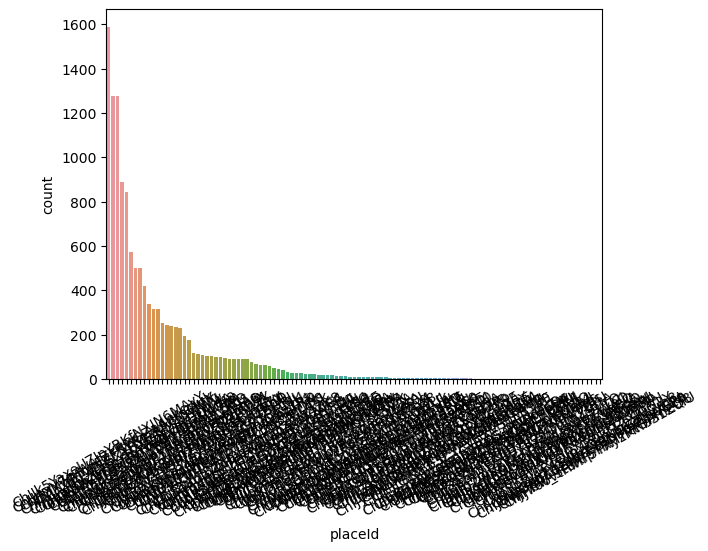

In [3]:
g=sns.countplot(x=datos["placeId"], order = datos["placeId"].value_counts().index)
plt.xticks(rotation=30)
plt.show()

In [4]:
grouped_data=datos.groupby("placeId")["placeId"].count()  
grouped_data.describe()

count     111.000000
mean      114.045045
std       264.464378
min         1.000000
25%         2.000000
50%        11.000000
75%        91.000000
max      1588.000000
Name: placeId, dtype: float64

In [5]:
# Filter the DataFrame to show only rows with empty spaces
df_filtered = datos[~datos['traduccion'].str.contains(r'^\s*$')]
df_filtered 

Id                      placeId  \
0         257  ChIJLTxz75CNIpYRWxjHYdRhlrc   
1         258  ChIJLTxz75CNIpYRWxjHYdRhlrc   
2         259  ChIJLTxz75CNIpYRWxjHYdRhlrc   
3         260  ChIJLTxz75CNIpYRWxjHYdRhlrc   
4         262  ChIJLTxz75CNIpYRWxjHYdRhlrc   
...       ...                          ...   
12654  278290  ChIJvfJSUDOKF5YRZe9GgfAODLc   
12655  278292  ChIJvfJSUDOKF5YRZe9GgfAODLc   
12656  278306  ChIJH4JP_-Tb9b0RzrxQFWoFaew   
12657  278311  ChIJH4JP_-Tb9b0RzrxQFWoFaew   
12658  278314  ChIJ766vtHlhF5YRyzMnbS1Z0iU   

                                 place name Categoria query  Year  \
0      Acceso a la Playa de Quincho Mutrico   national park  2023   
1      Acceso a la Playa de Quincho Mutrico   national park  2023   
2      Acceso a la Playa de Quincho Mutrico   national park  2022   
3      Acceso a la Playa de Quincho Mutrico   national park  2022   
4      Acceso a la Playa de Quincho Mutrico   national park  2022   
...                                     ...             ...   ...   
12654                       Portal Del Lago   national park  2018   
12655                       Portal Del Lago   national park  2018   
12656          Reserva Nacional Lago Palena   national park  2018   
12657          Reserva Nacional Lago Palena   national park  2016   
12658                 Vicente Perez Rosales   national park  2023   

                                                    text  stars Idioma  \
0      Lugar específico para disfrutar de pesca con f...    4.0     es   
1                                           Veo una vaca    5.0     es   
2                            Muy lindo y tranquilo lugar    5.0     es   
3                                    El lugar muy bonito    4.0     es   
4                   Muy bonita vista, ideal para pescar.    5.0     es   
...                                                  ...    ...    ...   
12654                          Experiencia inolvidable!!    5.0     es   
12655               Hermosos paisajes y excelente camino    5.0     es   
12656  Maravilloso lugar!!, único, aún inexplorado, c...    5.0     es   
12657                        súper lindo el lugar :):):)    5.0     es   
12658  Demasiado precioso y bien conservado, increíbl...    5.0     es   

                                              traduccion       nps  \
0      lugar especifico para disfrutar de pesca con f...  promotor   
1                                           veo una vaca  promotor   
2                            muy lindo y tranquilo lugar  promotor   
3                                    el lugar muy bonito  promotor   
4                     muy bonita vista ideal para pescar  promotor   
...                                                  ...       ...   
12654                            experiencia inolvidable  promotor   
12655               hermosos paisajes y excelente camino  promotor   
12656  maravilloso lugar unico aun inexplorado con ve...  promotor   
12657                               super lindo el lugar  promotor   
12658  demasiado precioso y bien conservado increible...  promotor   

                                              lemmatized  
0      lugar especifico para disfrutar de pesca con f...  
1                                           ver uno vaca  
2                          mucho lindo y tranquilo lugar  
3                                  el lugar mucho bonito  
4                   mucho bonito vista ideal para pescar  
...                                                  ...  
12654                            experiencia inolvidable  
12655                 hermoso paisaje y excelente camino  
12656  maravilloso lugar unico aun inexplorado con ve...  
12657                               super lindo el lugar  
12658  demasiado precioso y bien conservar increible ...  

[12659 rows x 11 columns]

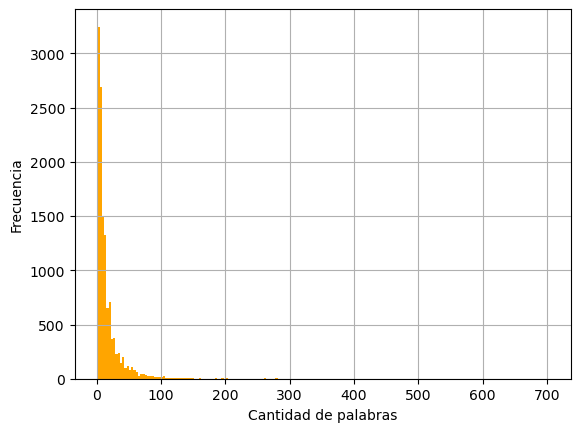

count    12659.000000
mean        16.543487
std         24.730752
min          1.000000
25%          4.000000
50%          9.000000
75%         19.000000
max        702.000000
Name: traduccion, dtype: float64

In [6]:
# Se divide cada texto en la columna 'traduccion' en palabras utilizando el método str.split()
# Luego, se calcula la longitud de cada lista de palabras y se crea un histograma de la cantidad de palabras
df_filtered['traduccion'].str.split().map(lambda x: len(x)).hist(bins=200, color='orange')

# Se agrega etiquetas a los ejes del histograma
plt.xlabel('Cantidad de palabras')
plt.ylabel('Frecuencia')

# Se muestra el histograma
plt.show()

# Se calculan estadísticas descriptivas de la cantidad de palabras en los textos de la columna 'traduccion'
df_filtered['traduccion'].str.split().map(lambda x: len(x)).describe()

In [7]:
df_filtered['cantidad_palabras']=df_filtered['traduccion'].str.split().map(lambda x: len(x))
df_filtered=df_filtered[df_filtered['cantidad_palabras']>=2]
df_filtered

Id                      placeId  \
0         257  ChIJLTxz75CNIpYRWxjHYdRhlrc   
1         258  ChIJLTxz75CNIpYRWxjHYdRhlrc   
2         259  ChIJLTxz75CNIpYRWxjHYdRhlrc   
3         260  ChIJLTxz75CNIpYRWxjHYdRhlrc   
4         262  ChIJLTxz75CNIpYRWxjHYdRhlrc   
...       ...                          ...   
12654  278290  ChIJvfJSUDOKF5YRZe9GgfAODLc   
12655  278292  ChIJvfJSUDOKF5YRZe9GgfAODLc   
12656  278306  ChIJH4JP_-Tb9b0RzrxQFWoFaew   
12657  278311  ChIJH4JP_-Tb9b0RzrxQFWoFaew   
12658  278314  ChIJ766vtHlhF5YRyzMnbS1Z0iU   

                                 place name Categoria query  Year  \
0      Acceso a la Playa de Quincho Mutrico   national park  2023   
1      Acceso a la Playa de Quincho Mutrico   national park  2023   
2      Acceso a la Playa de Quincho Mutrico   national park  2022   
3      Acceso a la Playa de Quincho Mutrico   national park  2022   
4      Acceso a la Playa de Quincho Mutrico   national park  2022   
...                                     ...             ...   ...   
12654                       Portal Del Lago   national park  2018   
12655                       Portal Del Lago   national park  2018   
12656          Reserva Nacional Lago Palena   national park  2018   
12657          Reserva Nacional Lago Palena   national park  2016   
12658                 Vicente Perez Rosales   national park  2023   

                                                    text  stars Idioma  \
0      Lugar específico para disfrutar de pesca con f...    4.0     es   
1                                           Veo una vaca    5.0     es   
2                            Muy lindo y tranquilo lugar    5.0     es   
3                                    El lugar muy bonito    4.0     es   
4                   Muy bonita vista, ideal para pescar.    5.0     es   
...                                                  ...    ...    ...   
12654                          Experiencia inolvidable!!    5.0     es   
12655               Hermosos paisajes y excelente camino    5.0     es   
12656  Maravilloso lugar!!, único, aún inexplorado, c...    5.0     es   
12657                        súper lindo el lugar :):):)    5.0     es   
12658  Demasiado precioso y bien conservado, increíbl...    5.0     es   

                                              traduccion       nps  \
0      lugar especifico para disfrutar de pesca con f...  promotor   
1                                           veo una vaca  promotor   
2                            muy lindo y tranquilo lugar  promotor   
3                                    el lugar muy bonito  promotor   
4                     muy bonita vista ideal para pescar  promotor   
...                                                  ...       ...   
12654                            experiencia inolvidable  promotor   
12655               hermosos paisajes y excelente camino  promotor   
12656  maravilloso lugar unico aun inexplorado con ve...  promotor   
12657                               super lindo el lugar  promotor   
12658  demasiado precioso y bien conservado increible...  promotor   

                                              lemmatized  cantidad_palabras  
0      lugar especifico para disfrutar de pesca con f...                  8  
1                                           ver uno vaca                  3  
2                          mucho lindo y tranquilo lugar                  5  
3                                  el lugar mucho bonito                  4  
4                   mucho bonito vista ideal para pescar                  6  
...                                                  ...                ...  
12654                            experiencia inolvidable                  2  
12655                 hermoso paisaje y excelente camino                  5  
12656  maravilloso lugar unico aun inexplorado con ve...                 32  
12657                               super lindo el lugar                  4  
12658  demasiado precioso y bien conserva

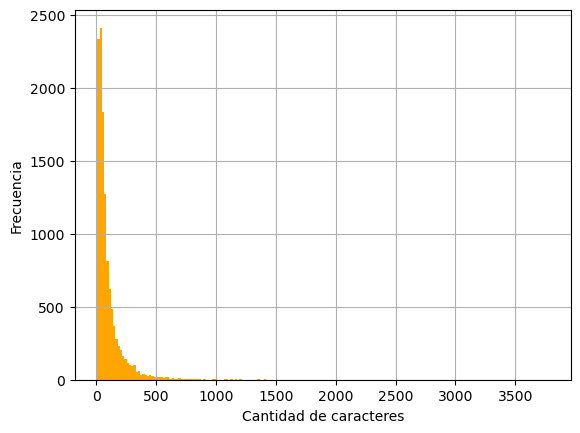

count    12137.000000
mean        99.615061
std        139.778364
min          7.000000
25%         31.000000
50%         57.000000
75%        114.000000
max       3776.000000
Name: traduccion, dtype: float64

In [8]:
# Cantidad de caracteres

# Se calcula el histograma de la longitud de los textos en la columna 'traduccion'
df_filtered['traduccion'].str.len().hist(bins=200, color='orange')

# Se agrega etiquetas a los ejes del histograma
plt.xlabel('Cantidad de caracteres')
plt.ylabel('Frecuencia')

# Se muestra el histograma
plt.show()

# Se calculan estadísticas descriptivas de la longitud de los textos en la columna 'traduccion'
df_filtered['traduccion'].str.len().describe()


In [9]:
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop + ['ser','tener','deber','haber','debe','lugar','hermoso','precioso','lindo','bello','bonito','vale','pena']


### Matriz DTM (matrix of token) con Sklearn

In [10]:
vect = CountVectorizer(stop_words=esp_stop)  
vects = vect.fit_transform(df_filtered['traduccion'])
td = pd.DataFrame(vects.todense()) 
td.columns = vect.get_feature_names_out() #get_feature_names()
td

abajo  abandonada  abandonado  abandonados  abandonan  abandono  \
0          0           0           0            0          0         0   
1          0           0           0            0          0         0   
2          0           0           0            0          0         0   
3          0           0           0            0          0         0   
4          0           0           0            0          0         0   
...      ...         ...         ...          ...        ...       ...   
12132      0           0           0            0          0         0   
12133      0           0           0            0          0         0   
12134      0           0           0            0          0         0   
12135      0           0           0            0          0         0   
12136      0           0           0            0          0         0   

       abaratar  abastecer  abastecido  abejas  ...  zoologico  zoom  zorrito  \
0             0          0           0       0  ...          0     0        0   
1             0          0           0       0  ...          0     0        0   
2             0          0           0       0  ...          0     0        0   
3             0          0           0       0  ...          0     0        0   
4             0          0           0       0  ...          0     0        0   
...         ...        ...         ...     ...  ...        ...   ...      ...   
12132         0          0           0       0  ...          0     0        0   
12133         0          0           0       0  ...          0     0        0   
12134         0          0           0       0  ...          0     0        0   
12135         0          0           0       0  ...          0     0        0   
12136         0          0           0       0  ...          0     0        0   

       zorritos  zorro  zorros  zorrosaves  zorzales  zum  zumbido  
0             0      0       0           0         0    0        0  
1             0      0       0           0         0    0        0  
2             0      0       0           0         0    0        0  
3             0      0       0           0         0    0        0  
4             0      0       0           0         0    0        0  
...         ...    ...     ...         ...       ...  ...      ...  
12132         0      0       0           0         0    0        0  
12133         0      0       0           0         0    0        0  
12134         0      0       0           0         0    0        0  
12135         0      0       0           0         0    0        0  
12136         0      0       0           0         0    0        0  

[12137 rows x 11236 columns]

In [11]:
columns = td.columns
td['id'] = td.index
df_tokens = pd.melt(td, id_vars='id', value_vars=columns)
df_tokens

id variable  value
0              0    abajo      0
1              1    abajo      0
2              2    abajo      0
3              3    abajo      0
4              4    abajo      0
...          ...      ...    ...
136371327  12132  zumbido      0
136371328  12133  zumbido      0
136371329  12134  zumbido      0
136371330  12135  zumbido      0
136371331  12136  zumbido      0

[136371332 rows x 3 columns]

In [12]:
tokens_counts = pd.DataFrame(df_tokens.groupby(['variable'])['value'].sum())
tokens_counts = tokens_counts.reset_index()
tokens_count = tokens_counts[tokens_counts.value>3]
tokens_count=tokens_count.rename(columns={"variable": "token"}) 
tokens_count=tokens_count.rename(columns={"value": "counts"}) 
tokens_count 

token  counts
0           abajo      12
2      abandonado       8
14        abierta      30
15       abiertas       7
16        abierto      35
...           ...     ...
11225       zonas      51
11228     zorrito       6
11229    zorritos       5
11230       zorro      10
11231      zorros      27

[3064 rows x 2 columns]

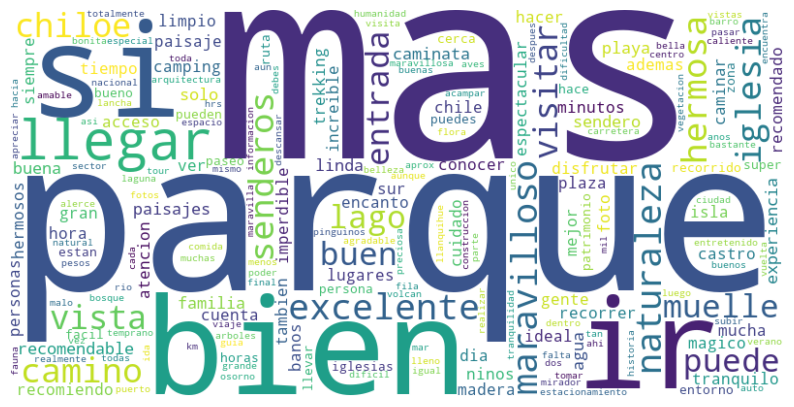

In [13]:
from wordcloud import WordCloud

data = dict(zip(tokens_count['token'].tolist(), tokens_count['counts'].tolist()))
wc = WordCloud(background_color='white',width=800, height=400, max_words=200).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
from nltk import word_tokenize, bigrams, trigrams
ngramos = []
for _, mytext in df_filtered['traduccion'].iteritems():
    tokens = word_tokenize(mytext)
    tokens = [x for x in tokens if x not in esp_stop]
    if len(tokens) > 1:
        bi_tokens = [' '.join(x) for x in list(bigrams(tokens))]
        ngramos.extend(bi_tokens)

ngram = pd.DataFrame(list(zip(ngramos)), columns=['ngram'])
ngram_count = ngram['ngram'].value_counts().rename_axis('ngram').reset_index(name='counts')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7076\2432455531.py:3: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _, mytext in df_filtered['traduccion'].iteritems():


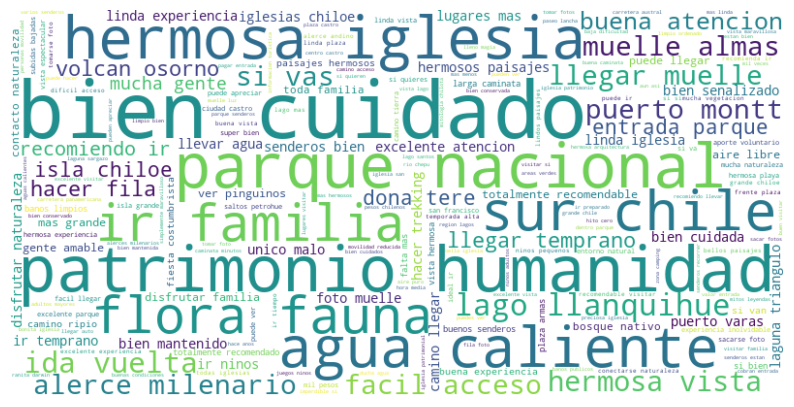

In [15]:
data = dict(zip(ngram_count['ngram'].tolist(), ngram_count['counts'].tolist()))
wc = WordCloud(background_color='white',width=800, height=400, max_words=200).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
#puerto mont
#puerto varas
# muellde de las almas
#plaza de armas


In [17]:
ngramos = []
for _, mytext in df_filtered['traduccion'].iteritems():
    tokens = word_tokenize(mytext)
    tokens = [x for x in tokens if x not in esp_stop]
    if len(tokens) > 2:  # Check if there are enough tokens for a trigram
        tri_tokens = [' '.join(x) for x in list(trigrams(tokens))]
        ngramos.extend(tri_tokens)

ngram = pd.DataFrame(list(zip(ngramos)), columns=['ngram'])
ngram_count = ngram['ngram'].value_counts().rename_axis('ngram').reset_index(name='counts')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7076\3243715586.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for _, mytext in df_filtered['traduccion'].iteritems():


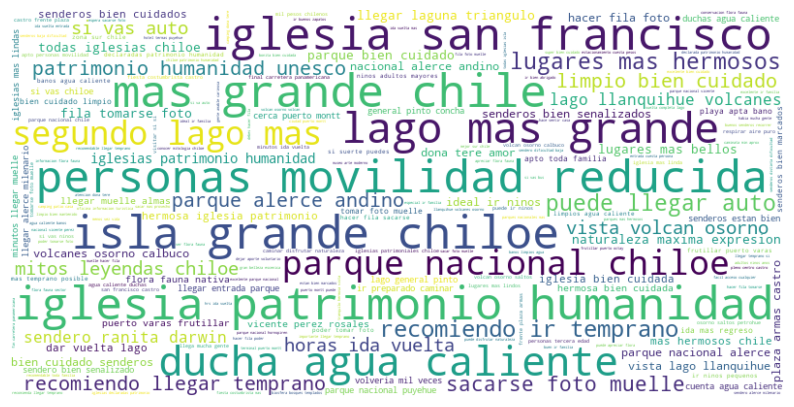

In [18]:
data = dict(zip(ngram_count['ngram'].tolist(), ngram_count['counts'].tolist()))
wc = WordCloud(background_color='white',width=800, height=400, max_words=200).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [20]:
# Function to filter stopwords from a text
def filter_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in esp_stop]
    return ' '.join(filtered_words)

# Apply the filter_stopwords function to the 'text' column and create a new 'filtered_text' column
df_filtered['lemmatized_stop'] = df_filtered['lemmatized'].apply(filter_stopwords)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7076\1962935978.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['lemmatized_stop'] = df_filtered['lemmatized'].apply(filter_stopwords)


In [21]:
import pandas as pd
import nltk
from nltk.util import bigrams

# Download the NLTK data if you haven't already
nltk.download('punkt')


# Define the list of bigrams to replace
bigram_replacements = {
    ('patrimonio', 'humanidad'): 'patrimonio_humanidad',
    ('san', 'francisco'): 'san_francisco',
    ('puerto', 'varas'): 'puerto_varas',
    ('puerto', 'montt'): 'puerto_montt',
    ('plaza', 'arma'): 'plaza_de_armas',
    ('muelle', 'alma'): 'muelle_de_las_almas',
}

# Function to replace bigrams
def replace_with_bigram(text, bigram_replacements):
    words = nltk.word_tokenize(text)

    for bigram_pair, bigram_keyword in bigram_replacements.items():
        bigram_occurrences = [(i, i + 2) for i in range(len(words) - 1) if words[i] == bigram_pair[0] and words[i + 1] == bigram_pair[1]]

        for start, end in reversed(bigram_occurrences):
            words[start:end + 1] = [bigram_keyword]

    return ' '.join(words)

# Replace bigrams in the "text" column
df_filtered['lemmatized_stop_bigramas'] = df_filtered['lemmatized_stop'].apply(lambda x: replace_with_bigram(x, bigram_replacements))
df_filtered



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Usuario\AppData\Local\Temp\ipykernel_7076\1469495582.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['lemmatized_stop_bigramas'] = df_filtered['lemmatized_stop'].apply(lambda x: replace_with_bigram(x, bigram_replacements))


Id                      placeId  \
0         257  ChIJLTxz75CNIpYRWxjHYdRhlrc   
1         258  ChIJLTxz75CNIpYRWxjHYdRhlrc   
2         259  ChIJLTxz75CNIpYRWxjHYdRhlrc   
3         260  ChIJLTxz75CNIpYRWxjHYdRhlrc   
4         262  ChIJLTxz75CNIpYRWxjHYdRhlrc   
...       ...                          ...   
12654  278290  ChIJvfJSUDOKF5YRZe9GgfAODLc   
12655  278292  ChIJvfJSUDOKF5YRZe9GgfAODLc   
12656  278306  ChIJH4JP_-Tb9b0RzrxQFWoFaew   
12657  278311  ChIJH4JP_-Tb9b0RzrxQFWoFaew   
12658  278314  ChIJ766vtHlhF5YRyzMnbS1Z0iU   

                                 place name Categoria query  Year  \
0      Acceso a la Playa de Quincho Mutrico   national park  2023   
1      Acceso a la Playa de Quincho Mutrico   national park  2023   
2      Acceso a la Playa de Quincho Mutrico   national park  2022   
3      Acceso a la Playa de Quincho Mutrico   national park  2022   
4      Acceso a la Playa de Quincho Mutrico   national park  2022   
...                                     ...             ...   ...   
12654                       Portal Del Lago   national park  2018   
12655                       Portal Del Lago   national park  2018   
12656          Reserva Nacional Lago Palena   national park  2018   
12657          Reserva Nacional Lago Palena   national park  2016   
12658                 Vicente Perez Rosales   national park  2023   

                                                    text  stars Idioma  \
0      Lugar específico para disfrutar de pesca con f...    4.0     es   
1                                           Veo una vaca    5.0     es   
2                            Muy lindo y tranquilo lugar    5.0     es   
3                                    El lugar muy bonito    4.0     es   
4                   Muy bonita vista, ideal para pescar.    5.0     es   
...                                                  ...    ...    ...   
12654                          Experiencia inolvidable!!    5.0     es   
12655               Hermosos paisajes y excelente camino    5.0     es   
12656  Maravilloso lugar!!, único, aún inexplorado, c...    5.0     es   
12657                        súper lindo el lugar :):):)    5.0     es   
12658  Demasiado precioso y bien conservado, increíbl...    5.0     es   

                                              traduccion       nps  \
0      lugar especifico para disfrutar de pesca con f...  promotor   
1                                           veo una vaca  promotor   
2                            muy lindo y tranquilo lugar  promotor   
3                                    el lugar muy bonito  promotor   
4                     muy bonita vista ideal para pescar  promotor   
...                                                  ...       ...   
12654                            experiencia inolvidable  promotor   
12655               hermosos paisajes y excelente camino  promotor   
12656  maravilloso lugar unico aun inexplorado con ve...  promotor   
12657                               super lindo el lugar  promotor   
12658  demasiado precioso y bien conservado increible...  promotor   

                                              lemmatized  cantidad_palabras  \
0      lugar especifico para disfrutar de pesca con f...                  8   
1                                           ver uno vaca                  3   
2                          mucho lindo y tranquilo lugar                  5   
3                                  el lugar mucho bonito                  4   
4                   mucho bonito vista ideal para pescar                  6   
...                                                  ...                ...   
12654                            experiencia inolvidable                  2   
12655                 hermoso paisaje y excelente camino                  5   
12656  maravilloso lugar unico aun inexplorado con ve...                 32   
12657                               super lindo el lugar                  4   
12658  demasiado precioso y bi

In [ ]:
#import spacy
#!python -m spacy download es_core_news_sm
#nlp = spacy.load("es_core_news_sm")
#def tokenizar(text):
#    text = text.lower()
#    doc = nlp(text)
#    return [token.lemma_ for token in doc if not token.is_punct and not token.is_stop and token.is_alpha]

#df_filtered["tokens"] = df_filtered["traduccion"].apply(tokenizar)
#df_filtered

WORD EMBEDDING

In [22]:
import gensim
from gensim import corpora
from gensim import models

In [23]:
%%time
corpus = [text.split() for text in df_filtered['lemmatized_stop_bigramas']]
#corpus = [text for text in df_filtered['tokens']]
print(corpus)

[['especifico', 'disfrutar', 'pesca', 'familia'], ['ver', 'vaca'], ['tranquilo'], [], ['vista', 'ideal', 'pescar'], ['tranquilo', 'cercano', 'puerto_montt'], ['maravilloso'], ['camino', 'transitable'], ['parque', 'abrir', 'manana', 'sendero', 'maravilloso', 'poder', 'apreciar', 'distinto', 'tipo', 'arbol', 'gigante', 'super', 'bien', 'marcado', 'ruta', 'asi', 'q', 'perder', 'mirador', 'frente', 'entrada', 'encontrar', 'rio', 'poder', 'visitar', 'conocer', 'sector', 'parque', 'indiscutiblemente', 'volver', 'ir', 'buscar', 'laguna', 'sargazo', 'guardaparque', 'decir', 'camino', 'posterior', 'ida', 'saber', 'si', 'existir', 'entrar', 'laguna', 'seguir', 'vehiculo', 'camino', 'bordear', 'rio', 'llegar', 'segundo', 'entrada', 'parque', 'lamentablemente', 'guarda', 'parque', 'q', 'alli', 'parecer', 'conocer', 'tratar', 'volver', 'ir'], ['excelente', 'ir', 'familia', 'entrada', 'cerca', 'kms', 'ripio', 'llegar', 'entrada', 'ahi', 'mas', 'recorrido', 'pie', 'diverso', 'sendero', 'poder', 'hace

In [24]:
from gensim.models import Word2Vec

In [25]:
model = Word2Vec(corpus, min_count=3,vector_size= 100, window =5, sg = 1)

In [26]:
model.wv.most_similar('castro')

[('quellon', 0.9152025580406189),
 ('ciudad', 0.8903403878211975),
 ('ancud', 0.8861454129219055),
 ('centro', 0.8529020547866821),
 ('ubicado', 0.8520749807357788),
 ('terminal', 0.8396891355514526),
 ('dalcahue', 0.8330601453781128),
 ('hito', 0.8321727514266968),
 ('frente', 0.8298897743225098),
 ('plaza_de_armas', 0.829264223575592)]

In [27]:
model.wv.most_similar('iglesia')

[('patrimonio_humanidad', 0.9628983736038208),
 ('patrimonial', 0.9610754251480103),
 ('historico', 0.9409970045089722),
 ('antiguo', 0.9365700483322144),
 ('patrimonio', 0.9286792874336243),
 ('dalcahue', 0.9273905158042908),
 ('construccion', 0.9194387197494507),
 ('frente', 0.915229856967926),
 ('construido', 0.9143263101577759),
 ('arquitectura', 0.9103792905807495)]

In [56]:
model.wv.most_similar('treking')

[('cansador', 0.9914804697036743),
 ('requerir', 0.9912765026092529),
 ('trayecto', 0.9890719056129456),
 ('duracion', 0.9864823818206787),
 ('empinado', 0.9863159656524658),
 ('complejidad', 0.9845548868179321),
 ('distancia', 0.9838278293609619),
 ('total', 0.9827108383178711),
 ('fisico', 0.9821040630340576),
 ('hr', 0.9818034768104553)]

In [29]:
# Access the attribute vector
attribute_vector = model.wv.vectors
attribute_vector

array([[-1.05461106e-01,  2.33955592e-01,  2.36023143e-02, ...,
        -6.23140372e-02,  6.59312075e-03, -7.05019459e-02],
       [ 5.07846102e-02,  1.95582449e-01,  7.11860582e-02, ...,
        -7.30600432e-02, -3.38539258e-02, -6.92069754e-02],
       [ 2.83004105e-01,  2.57206470e-01, -1.38880596e-01, ...,
        -1.55205160e-01,  1.25084415e-01, -2.15458319e-01],
       ...,
       [-2.64513884e-02,  1.23600133e-01,  5.57921194e-02, ...,
        -9.47170332e-02,  5.88909304e-03, -2.25887243e-02],
       [-2.93000881e-02,  1.19349331e-01,  4.19601761e-02, ...,
        -7.97862932e-02, -3.15603577e-02,  1.35228271e-04],
       [-7.97741674e-03,  1.17451727e-01,  3.73772457e-02, ...,
        -7.83699155e-02, -1.62387900e-02, -1.70851238e-02]], dtype=float32)

In [30]:
model.wv.vectors.shape

(2837, 100)

In [31]:
model.wv.key_to_index

{'buen': 0,
 'poder': 1,
 'ir': 2,
 'sendero': 3,
 'parque': 4,
 'mas': 5,
 'llegar': 6,
 'maravilloso': 7,
 'bien': 8,
 'iglesia': 9,
 'visitar': 10,
 'si': 11,
 'excelente': 12,
 'hacer': 13,
 'paisaje': 14,
 'naturaleza': 15,
 'camino': 16,
 'chiloe': 17,
 'ver': 18,
 'valer': 19,
 'lago': 20,
 'entrada': 21,
 'agua': 22,
 'vista': 23,
 'recomendable': 24,
 'caminata': 25,
 'playa': 26,
 'conocer': 27,
 'muelle': 28,
 'caminar': 29,
 'familia': 30,
 'tranquilo': 31,
 'solo': 32,
 'persona': 33,
 'mejor': 34,
 'experiencia': 35,
 'limpio': 36,
 'hora': 37,
 'disfrutar': 38,
 'llevar': 39,
 'foto': 40,
 'cuidado': 41,
 'acceso': 42,
 'bano': 43,
 'camping': 44,
 'recomer': 45,
 'dia': 46,
 'castro': 47,
 'encontrar': 48,
 'gente': 49,
 'recorrer': 50,
 'espectacular': 51,
 'nino': 52,
 'tomar': 53,
 'pasar': 54,
 'magico': 55,
 'chile': 56,
 'minuto': 57,
 'contar': 58,
 'zona': 59,
 'dar': 60,
 'trekking': 61,
 'recomendado': 62,
 'madera': 63,
 'increible': 64,
 'bosque': 65,
 'enca

In [32]:
model.wv['pudu']

array([-0.02884592,  0.23021322,  0.12237585, -0.14575693,  0.21446808,
       -0.10953237,  0.12784009,  0.40972015, -0.2024467 , -0.07295044,
       -0.01811283, -0.44646683, -0.11184993,  0.04677435,  0.09460089,
       -0.04016595,  0.0951317 , -0.14122726,  0.00487579, -0.36638612,
        0.04765899,  0.14085627,  0.1764971 ,  0.05419417, -0.08274424,
        0.08092844,  0.00823301, -0.07337833, -0.07171275,  0.03401614,
        0.18624045, -0.00469767, -0.03314491, -0.12779914,  0.04231953,
        0.12080888,  0.03796819, -0.16938707, -0.01460875, -0.36756706,
        0.09492841, -0.22090977, -0.11484699,  0.04595108,  0.08662957,
       -0.11331191, -0.02615313,  0.07496359,  0.04510722, -0.11655574,
        0.04561404, -0.20679542,  0.04874812, -0.10443918, -0.06389119,
       -0.04826503,  0.25723618, -0.10594271, -0.1113115 ,  0.0415427 ,
        0.05029171,  0.1312414 ,  0.00427702,  0.05642583, -0.15157314,
        0.1112396 ,  0.17011274,  0.30529326, -0.1308218 ,  0.17

In [48]:
import umap.umap_ as umap

# seleccionar algunos embeddings para mostrar
embeddings_por_proyectar = model.wv.vectors[0:10000]
vocab_por_proyectar = list(model.wv.key_to_index.keys())[0:10000]

# proyectar embeddings usando UMAP.
proyector = umap.UMAP(n_components=2, random_state=10)
proyeccion = proyector.fit_transform(embeddings_por_proyectar)

# crear un dataframe con las proyecciones
df_proyeccion = pd.DataFrame([vocab_por_proyectar, proyeccion[:, 0], proyeccion[:, 1]]).T
df_proyeccion.columns=['palabra', 'x', 'y']

In [34]:
import plotly.express as px
import numpy as np

def exec_query(modelo, palabra, topn):
    """dada una palabra, encuentra y proyecta sus similares."""
    
    # calcular palabras similares
    similares = modelo.wv.most_similar(palabra, topn)
    #model.wv.most_similar('iglesia')
    # proyectar palabra query
    proyeccion = proyector.transform([model.wv[palabra]])
    query = [{
        'palabra': palabra, 
        'x': proyeccion[0, 0],
        'y': proyeccion[0, 1],
        'similitud': 1,            
    }]
        
    # proyectar palabras similares
    for word, sim in similares:
        proyeccion = proyector.transform([model.wv[word]])
        query.append({
            'palabra': word, 
            'x': proyeccion[0, 0], 
            'y': proyeccion[0, 1],
            'similitud': sim,
        })
    
    df_query = pd.DataFrame(query)
    
    return df_query

def plot_embeddings(model, projections, query=None, topn=20):
    """coordina la creación de los gráficos de proyecciones de embeddings"""

    if query is not None: 
        
        if query not in model.wv:
            raise ValueError('No existe la palabra en el modelo')
        
        df_query = exec_query(model, query, topn=topn)
        display(df_query)
        plot_df = df_query.fillna(0).drop_duplicates(subset='palabra')
        plot_df['tamaño'] = plot_df['similitud'].apply(lambda x: 2 if x <= 0.001 else 20)
        title=f'Proyección de los Embeddings mas similares a {query}'

    else: 
        plot_df = projections.loc[0:10000]
        title='Proyección de los primeros 10.000 Word Embeddings'

    fig = px.scatter(
        plot_df, 
        x='x', 
        y='y', 
        hover_name='palabra',
        range_x=(projections['x'].min() - 1, projections['x'].max() + 1),
        range_y=(projections['y'].min() - 1, projections['y'].max() + 1),
        color='similitud' if query is not None else None,
        title=title,
    )

    if query is not None:
        fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
        fig.add_trace(px.scatter(
            projections.loc[0:10000],
            x='x',
            y='y', 
            hover_name='palabra',
            opacity=0.2).data[0])
    
    return fig

In [49]:
plot_embeddings(model, df_proyeccion)

In [51]:
plot_embeddings(model, df_proyeccion, 'iglesia',topn=10)

palabra         x         y  similitud
0                iglesia  6.565166  6.009953   1.000000
1                  plaza  6.153272  6.091551   0.344420
2              artesania  4.633943  6.506959   0.307724
3                 madera  6.585273  6.086746   0.303188
4                 frente  6.595187  6.106320   0.299225
5                 centro  6.217689  6.165740   0.292766
6                ubicado  6.783415  6.108256   0.287181
7                  feria  5.963042  6.163838   0.281760
8                 tipico  6.152076  6.168279   0.271113
9   patrimonio_humanidad  6.600286  6.048311   0.269702
10           informacion  5.514338  6.578692   0.268239

In [53]:
plot_embeddings(model, df_proyeccion, 'pudu',topn=10)

palabra          x          y  similitud
0      pudu   7.996321   7.904668   1.000000
1    sector  10.741470  11.332338   0.594237
2       rio   8.876904   7.459489   0.554020
3     salto  12.113281   9.152603   0.519704
4      agua   3.801414   6.660803   0.519308
5       dos  12.109715  10.320330   0.478598
6       ave   8.032490   7.475413   0.465454
7   tambien   4.177751   7.678348   0.464458
8     fauna   8.163265   7.407458   0.460555
9    varios  11.302341  11.233348   0.452007
10  especie   7.935658   7.528831   0.441843

In [54]:
plot_embeddings(model, df_proyeccion, 'alerce')

palabra          x          y  similitud
0       alerce  12.073243   9.091709   1.000000
1      sendero  12.617667   9.583085   0.437480
2   senalizado  12.612166  10.033186   0.433415
3   dificultad  12.767291   9.281687   0.372193
4       parque  12.207794  10.072663   0.370582
5    milenario  12.133826   9.050458   0.355619
6         bien   5.617069   7.142916   0.350859
7        facil  12.717962   9.908921   0.330088
8      cuidado   5.591759   7.150501   0.326488
9       acceso  12.353360  10.684375   0.307402
10       conaf  12.040655  11.025674   0.299179

In [59]:
from scipy.spatial.distance import cosine

target_words = ['iglesia', 'castro']

# Get the words in the vocabulary
vocab = list(model.wv.key_to_index.keys())

# Create an empty similarity matrix
similarity_matrix = np.zeros((len(target_words), len(vocab)))

# Compute the similarity between each pair of words
for i, word1 in enumerate(target_words):
    for j, word2 in enumerate(vocab):
        similarity_matrix[i, j] = 1 - cosine(model.wv[word1], model.wv[word2])


In [60]:
similarity_matrix

array([[0.37238315, 0.43464923, 0.30894053, ..., 0.70316023, 0.68818825,
        0.65767032],
       [0.31443974, 0.49565113, 0.47861242, ..., 0.65160048, 0.60970318,
        0.64194548]])

In [71]:
# Set the similarity threshold (adjust this based on your preference)
similarity_threshold = 0.88

# Filter word pairs based on the similarity threshold
edges = []
for i, word1 in enumerate(target_words):
    for j, word2 in enumerate(vocab):
        # Exclude the diagonal and filter based on the similarity threshold
        if i != j and similarity_matrix[i, j] >= similarity_threshold:
            edges.append((word1, word2))

In [72]:
edges 

[('iglesia', 'iglesia'),
 ('iglesia', 'chiloe'),
 ('iglesia', 'madera'),
 ('iglesia', 'isla'),
 ('iglesia', 'historia'),
 ('iglesia', 'grande'),
 ('iglesia', 'plaza'),
 ('iglesia', 'ciudad'),
 ('iglesia', 'arquitectura'),
 ('iglesia', 'turistico'),
 ('iglesia', 'patrimonio_humanidad'),
 ('iglesia', 'construccion'),
 ('iglesia', 'atractivo'),
 ('iglesia', 'interior'),
 ('iglesia', 'interesante'),
 ('iglesia', 'ubicado'),
 ('iglesia', 'tipico'),
 ('iglesia', 'chiloto'),
 ('iglesia', 'costumbrista'),
 ('iglesia', 'monumento'),
 ('iglesia', 'frente'),
 ('iglesia', 'fiesta'),
 ('iglesia', 'mitologia'),
 ('iglesia', 'detalle'),
 ('iglesia', 'historico'),
 ('iglesia', 'antiguo'),
 ('iglesia', 'patrimonio'),
 ('iglesia', 'hecho'),
 ('iglesia', 'mito'),
 ('iglesia', 'dalcahue'),
 ('iglesia', 'patrimonial'),
 ('iglesia', 'cultura'),
 ('iglesia', 'catedral'),
 ('iglesia', 'pueblo'),
 ('iglesia', 'trabajo'),
 ('iglesia', 'construido'),
 ('iglesia', 'leyenda'),
 ('iglesia', 'cultural'),
 ('iglesia'

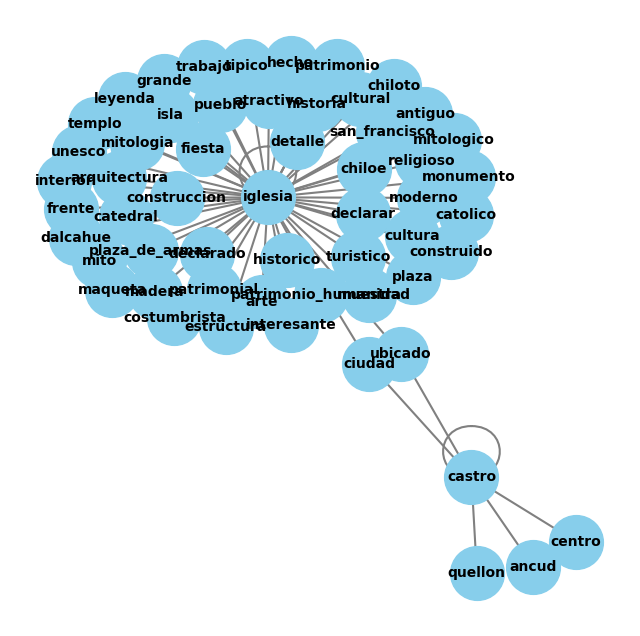

In [73]:
# Create a graph
G = nx.Graph()
G.add_edges_from(edges)

# Create a new figure and axis
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Positions nodes using the spring layout algorithm
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, font_weight='bold', edge_color='gray', width=1.5, ax=ax)

# Show the plot
plt.show()

In [74]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
from nltk.tokenize import word_tokenize  # Requires nltk library, install using `pip install nltk`
import pandas as pd

def generate_co_occurrence_network(texts, window_size):
    graph = nx.Graph()
    co_occurrence_count = defaultdict(int)

    for text in texts:
        words = word_tokenize(text.lower())

        for i, word in enumerate(words):
            start_idx = max(0, i - window_size)
            end_idx = min(len(words), i + window_size + 1)
            context = words[start_idx:end_idx]

            for pair in combinations(context, 2):
                co_occurrence_count[pair] += 1

    for (word1, word2), count in co_occurrence_count.items():
        graph.add_edge(word1, word2, weight=count)

    return graph

def plot_co_occurrence_network(graph):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, k=0.5, iterations=50)
    node_sizes = [len(graph[node]) * 300 for node in graph.nodes()]
    edge_weights = [graph[u][v]['weight'] for u, v in graph.edges()]

    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color='skyblue')
    nx.draw_networkx_edges(graph, pos, width=edge_weights, edge_color='gray')
    nx.draw_networkx_labels(graph, pos, font_size=10, font_family='sans-serif')

    plt.axis('off')
    plt.title("Co-occurrence Network Word Plot")
    plt.show()



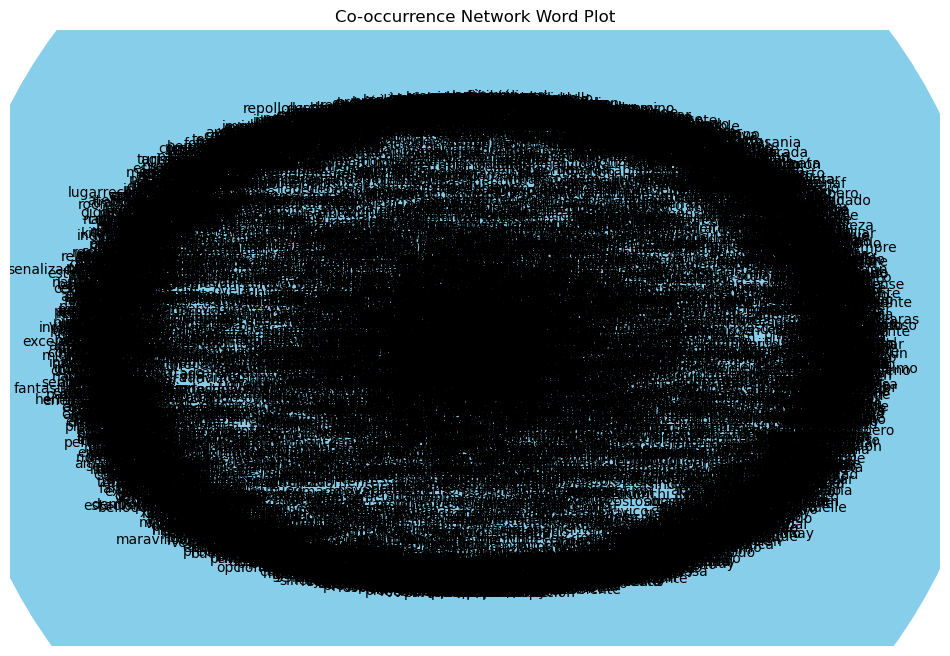

In [76]:
# Extract texts from the DataFrame
texts = df_filtered['lemmatized_stop_bigramas'].tolist()

# Generate the co-occurrence network
co_occurrence_graph = generate_co_occurrence_network(texts, 2)

# Plot the co-occurrence network
plot_co_occurrence_network(co_occurrence_graph)


In [78]:
G=co_occurrence_graph

In [79]:
compon=[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
compon
print('Non connected: '+ str(sum(compon)-compon[0]))
print('Connected nodes en la compoenente gigante: '+ str(compon[0]) +' de '+str(G.number_of_nodes())+' nodos totales.')

print(compon)



# Let's extract and use only the giant component
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

Non connected: 5
Connected nodes en la compoenente gigante: 7665 de 7670 nodos totales.
[7665, 2, 2, 1]


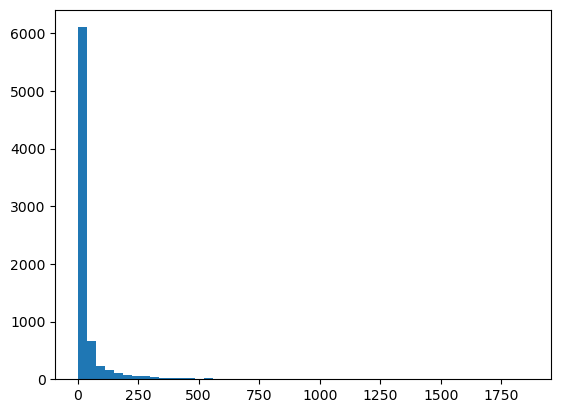

In [82]:
F = S[0]
dict1=dict(F.degree())  # node 0 has degree 1
sorted_dict = {}
sorted_keys = sorted(dict1, key=dict1.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = dict1[w]

#plt.hist((dict1.values()), bins=np.logspace(0,3))
#plt.loglog()
plt.hist((dict1.values()), bins=50)
plt.show()

In [85]:
N10 = len(F)
L10 = F.size()
degrees10 = list(dict(F.degree()).values())
kmin10 = min(degrees10)
kmax10 = max(degrees10)
print("Número de nodos: ", N10)
print("Número de enlaces: ", L10)
print('-------')
print("Grado promedio: ", 2*L10/N10) 
print('-------')
print("Grado mínimo: ", kmin10)
print("Grado máximo: ", kmax10)
print('-------')
print('Densidad: ', nx.density(F))
#print('Diametro: ',nx.diameter(F))

#nx.draw_networkx(F)

Número de nodos:  7665
Número de enlaces:  166970
-------
Grado promedio:  43.56686236138291
-------
Grado mínimo:  1
Grado máximo:  1863
-------
Densidad:  0.005684611477215933


In [110]:
def filter_network(graph, threshold):
    # Convert the graph to the adjacency matrix
    adjacency_matrix = nx.to_numpy_matrix(graph)

    # Create a copy of the adjacency matrix to avoid modifying the original matrix
    filtered_matrix = np.copy(adjacency_matrix)

    # Set edges below the threshold to zero (remove the edges)
    filtered_matrix[filtered_matrix < threshold] = 0

    # Create a new filtered graph with node names conserved
    filtered_graph = nx.Graph()
    node_names = list(graph.nodes())  # Get the names of all nodes in the original graph

    for i, node_i in enumerate(node_names):
        for j, node_j in enumerate(node_names):
            weight = filtered_matrix[i, j]
            if weight > 0:
                filtered_graph.add_edge(node_i, node_j, weight=weight)

    return filtered_graph

# Example usage:
# Let's say you have a graph 'F' with node names and an associated threshold value.
# Set the threshold value you want to use for filtering, for example, 0.5.
threshold_value = 50
network = filter_network(F, threshold_value)


In [111]:
N10 = len(network)
L10 = network.size()
degrees10 = list(dict(network.degree()).values())
kmin10 = min(degrees10)
kmax10 = max(degrees10)
print("Número de nodos: ", N10)
print("Número de enlaces: ", L10)
print('-------')
print("Grado promedio: ", 2*L10/N10) 
print('-------')
print("Grado mínimo: ", kmin10)
print("Grado máximo: ", kmax10)
print('-------')
print('Densidad: ', nx.density(network))

Número de nodos:  182
Número de enlaces:  289
-------
Grado promedio:  3.1758241758241756
-------
Grado mínimo:  1
Grado máximo:  29
-------
Densidad:  0.01754598992168053


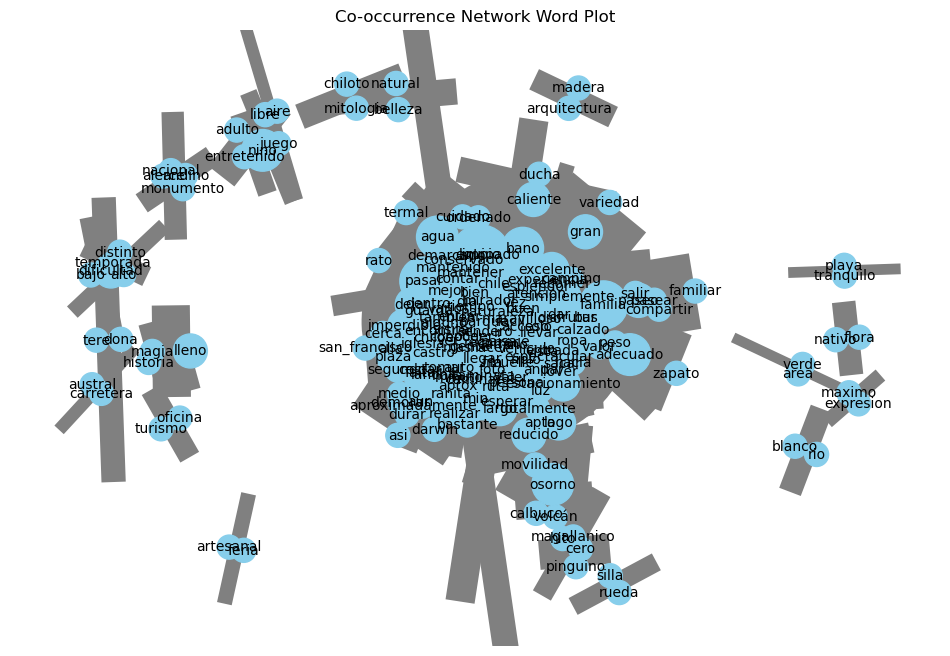

In [113]:
# Plot the co-occurrence network
plot_co_occurrence_network(network)

In [115]:
nx.write_gexf(network, "Red_Filtrada_Palabras.gexf")

# Ventana de 5 Palabras

In [122]:
# Extract texts from the DataFrame
texts = df_filtered['lemmatized_stop_bigramas'].tolist()

# Generate the co-occurrence network
co_occurrence_graph_5 = generate_co_occurrence_network(texts, 5)


In [123]:
G1=co_occurrence_graph_5

In [124]:
compon=[len(c) for c in sorted(nx.connected_components(G1), key=len, reverse=True)]
compon
print('Non connected: '+ str(sum(compon)-compon[0]))
print('Connected nodes en la compoenente gigante: '+ str(compon[0]) +' de '+str(G1.number_of_nodes())+' nodos totales.')

print(compon)



# Let's extract and use only the giant component
S1= [G1.subgraph(c).copy() for c in nx.connected_components(G1)]

Non connected: 5
Connected nodes en la compoenente gigante: 7665 de 7670 nodos totales.
[7665, 2, 2, 1]


In [125]:
F1 = S1[0]

In [128]:
# Example usage:
# Let's say you have a graph 'F' with node names and an associated threshold value.
# Set the threshold value you want to use for filtering, for example, 0.5.
threshold_value = 150
network1 = filter_network(F1, threshold_value)

In [129]:
N10 = len(network1)
L10 = network.size()
degrees10 = list(dict(network1.degree()).values())
kmin10 = min(degrees10)
kmax10 = max(degrees10)
print("Número de nodos: ", N10)
print("Número de enlaces: ", L10)
print('-------')
print("Grado promedio: ", 2*L10/N10) 
print('-------')
print("Grado mínimo: ", kmin10)
print("Grado máximo: ", kmax10)
print('-------')
print('Densidad: ', nx.density(network1))

Número de nodos:  145
Número de enlaces:  289
-------
Grado promedio:  3.986206896551724
-------
Grado mínimo:  1
Grado máximo:  53
-------
Densidad:  0.035632183908045977


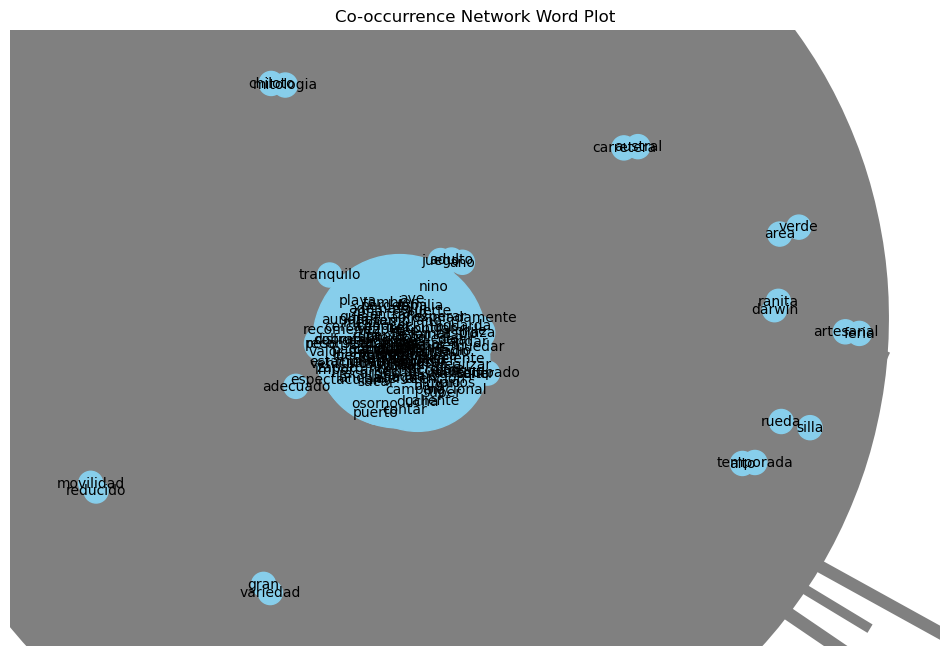

In [130]:
# Plot the co-occurrence network
plot_co_occurrence_network(network1)

In [132]:
nx.write_gexf(network1, "Red_Filtrada_Palabras_5.gexf")